# 전력 수요량 예측 모델링
Train 데이터로 모델을 학습시킨 후 Test로 검증한 후 예측합니다.

In [208]:
# import package
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta
%matplotlib inline

## 1. 데이터 불러오기

In [81]:
train = pd.read_csv("11회 data/train.csv")
#train['Time'] = pd.to_datetime(train['Time'])
#train = train.set_index('Time')

In [82]:
train.head()

,Time,X692,X1272,X553,X1299,X4,X598,X1003,X1010,X1216,...,X1164,X656,X1287,X324,X767,X1271,X1288,X58,X1033,X1163
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. 데이터 전처리

### 2-1. NA 처리
 - 이전부터 측정기가 없던 경우
 - 직전 시간대 전력 사용량 값이 높아 이후 값이 결측치일 경우
     - 값이 존재하는 index 사이의 결측치 갯수 구해서 1 이상인 경우에 중앙값 보다 큰 경우, 평균값으로 대체
     - 남은 NA값은 이전부터 측정기가 없던 경우 제외하고 최빈값으로 대체하기


### 2-2 NA처리를 위한 밑작업
+ loc : 인덱스 기준으로 행 데이터 읽기
+ iloc : 행 번호 기준으로 행 데이터 읽기


#### ex) X692 세대의 경우

In [85]:
ex1 = train.copy()  # 원본 데이터 보존을 위해 복사

In [86]:
ex1.columns

Index(['Time', 'X692', 'X1272', 'X553', 'X1299', 'X4', 'X598', 'X1003',
       'X1010', 'X1216',
       ...
       'X1164', 'X656', 'X1287', 'X324', 'X767', 'X1271', 'X1288', 'X58',
       'X1033', 'X1163'],
      dtype='object', length=1301)

In [87]:
ex1.loc[:,['X692']] # X692인 경우 모든 전력량
# ex1.iloc[:,0]  

,X692
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
16904,0.271
16905,0.341
16906,0.535
16907,0.379


In [134]:
X692 = ex1.loc[ ex1.iloc[:,2].isnull() == False ]['X692'].index
X692

Int64Index([13645, 13646, 13647, 13648, 13649, 13650, 13651, 13652, 13653,
            13654,
            ...
            16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907,
            16908],
           dtype='int64', length=3065)

In [135]:
print(X692[500:520])  # 값이 존재하는 다음 index
print(X692[499:519])  # 값이 존재하는 현재 index
print(X692[500:520] - X692[499:519] - 1)  # 다음index - 현재index

Int64Index([14209, 14210, 14211, 14212, 14213, 14214, 14215, 14216, 14217,
            14218, 14219, 14220, 14221, 14222, 14223, 14224, 14225, 14226,
            14227, 14228],
           dtype='int64')
Int64Index([14208, 14209, 14210, 14211, 14212, 14213, 14214, 14215, 14216,
            14217, 14218, 14219, 14220, 14221, 14222, 14223, 14224, 14225,
            14226, 14227],
           dtype='int64')
Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='int64')


#### 이를 모든 'X692'에 적용해보기

+ zip()

In [163]:
df_X692 = pd.DataFrame(list(zip(X692[:-1], X692[1:]-X692[:-1]-1)),
                       columns = ['Index', 'count'])

#마지막 값들이 결측일 경우를 추가하기 위한 코드
# df_X692.shape  # (3064, 2)
# X692[-1]  # X692의 뒤에서 첫번째
# 16908  # X692 전체 갯수
# 마지막 값이 Na가 아니면 0, 결측이면 개수만큼

df_X692.loc[df_X692.shape[0]+1] = (X692[-1] , 16908 - X692[-1])

In [164]:
# 결측치 갯수 기준 내림차순 정렬
df_X692.sort_values('count', ascending=False, inplace=True)

In [165]:
df_X692[df_X692['count']>0].head()

,Index,count
1150,14898,37
2773,16573,23
1108,14833,23
311,13982,22
1037,14751,11


In [166]:
df_X692[df_X692['count']>0].tail()

,Index,count
990,14700,1
205,13859,1
273,13931,1
228,13883,1
202,13855,1


### 2-3 결측치 대체 작업
#### 2-3-1 중앙값 이상의 값을 전력량 과다로 인한 NA발생으로 가정하고 평균값으로 대체

In [170]:
print('X692의 평균   :', round(ex1['X692'].mean(),3))
print('X692의 중앙값 :', ex1['X692'].median())

X692의 평균   : 0.372
X692의 중앙값 : 0.329


In [177]:
# 1. 평균값으로 결측치 대체

# NA존재하는 부분만 추출하여 df_X692_NA로 저장
df_X692_NA = df_X692[df_X692['count']>0]
df_X692_NA.sort_values('Index', inplace=True)  # Index열 위해서 sort
df_X692_NA = df_X692_NA.reset_index(drop=True)  # index 초기화

# 중앙값 고정
X692_median = ex1['X692'].median()

df_X692_NA

C:\Users\huiyeon\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Index,count
0,13667,1
1,13691,1
2,13715,1
3,13739,1
4,13763,1
5,13787,1
6,13811,1
7,13835,1
8,13855,1
9,13859,1


In [179]:
for i,j in zip(df_X692_NA['Index'], df_X692_NA['count']):
    # i:값이 존재하는 index, j:결측치갯수
    if ex1['X692'].iloc[i,]>=X692_median:
        # 현재 index에 존재하는 값이 중앙값 이상일 때만 zip
        ex1['X692'].iloc[i:i+j+1,] = ex1['X692'].iloc[i,]/(j+1)
    else:
        pass

C:\Users\huiyeon\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [183]:
print('결측치 대체 후 X692의 평균   :', round(ex1['X692'].mean(),3))
print('결측치 대체 후 X692의 중앙값 :', ex1['X692'].median())

결측치 대체 후 X692의 평균   : 0.363
결측치 대체 후 X692의 중앙값 : 0.328


In [215]:
# 결측치 대체 전 후 결측값 개수
print('결측치 대체 전 결측값 개수 :',train['X692'].isnull().sum())
print('결측치 대체 후 결측값 개수 :',ex1['X692'].isnull().sum())

결측치 대체 전 결측값 개수 : 13845
결측치 대체 후 결측값 개수 : 13769


In [209]:
# 한글 폰트 설정
mpl.rc('font', family='NanumGothic')
# 유니코드에서 음수 부호설정
mpl.rc('axes', unicode_minus=False)

Text(0.5, 1.0, '결측치 대체 전 X692 세대')

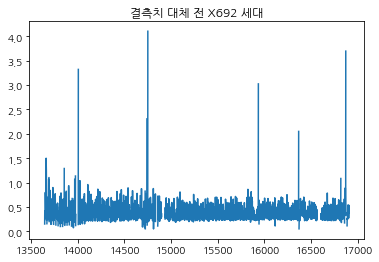

In [211]:
# X692 결측치 대체 전, 후 비교 plot
plt.plot(train['X692'])
plt.title("결측치 대체 전 X692 세대")

Text(0.5, 1.0, '결측치 대체 후 X692 세대')

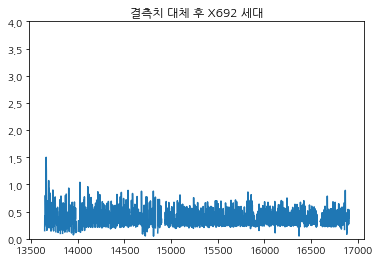

In [213]:
plt.ylim(0,4)
plt.plot(ex1['X692'])
plt.title("결측치 대체 후 X692 세대")

In [248]:
# 전체 train에 중앙값보다 큰 값은 평균으로 대체
ex2 = train.copy()  # 원본 데이터 보존을 위해

for k in range(1, len(ex2.columns)):
    # Time열 제외하고 k세대만큼 for문 동작
    train_median = ex2.iloc[:, k].median()  # k세대 중앙값 고정
    # ct : 결측치가 아닌 index 번호
    ct = ex2.loc[ex2.iloc[:, k].isnull() == False][ex2.columns[k]].index

    # Index : 값이존재하는 index, count :결측값 갯수
    df_train = pd.DataFrame(list(zip(ct[:-1], ct[1:] - ct[:-1]-1)),
                            columns=['Index', 'count'])
        
    df_train_NA = df_train[df_train['count'] > 0]  # NA존재하는 부분만 추출
    df_train_NA = df_train_NA.reset_index(drop=True)

    for i, j in zip(df_train_NA['Index'], df_train_NA['count']):
        # i:해당세대에서 값이 존재하는 index, j:결측치 갯수
        if ex2.iloc[i, k] >= train_median:
            # index에 존재하는 값이 해당 세대 중앙값 이상일 때,
            ex2.iloc[i:i+j+1, k] = ex2.iloc[i, k] / (j+1)
        else:
            pass
    if k % 100 == 0:
        print(k, "번째 실행중")

100 번째 실행중
200 번째 실행중
300 번째 실행중
400 번째 실행중
500 번째 실행중
600 번째 실행중
700 번째 실행중
800 번째 실행중
900 번째 실행중
1000 번째 실행중
1100 번째 실행중
1200 번째 실행중
1300 번째 실행중


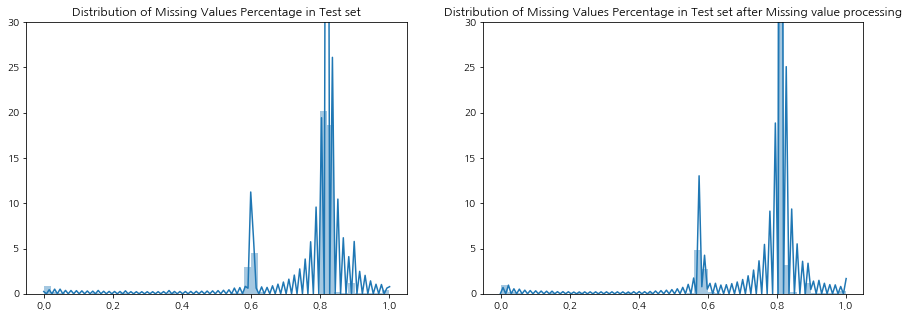

In [249]:
# 결측치 처리 전 후 plot 비율 비교하기
_, ax = plt.subplots(1,2, figsize=(15,5))

# 결측치 처리 전 plot
a = sns.distplot(train.isnull().mean(axis=0), ax=ax[0])
a.set(ylim=(0, 30))
ax[0].set_title('Distribution of Missing Values Percentage in Test set')

# 결측치 처리 후 plot
b=sns.distplot(ex2.isnull().mean(axis=0), ax=ax[1]) #test data에서의 결측치 비율을 시각화 하고, 이를 두 번째 그래프 창에 넣습니다.
b.set(ylim=(0, 30))
ax[1].set_title('Distribution of Missing Values Percentage in Test set after Missing value processing')
plt.show()

In [252]:
# 결측치 대체 전 후 결측값 개수
print('결측치 대체 전 결측값 개수 :',train.isnull().sum())
print('결측치 대체 후 결측값 개수 :',ex2.isnull().sum())

결측치 대체 전 결측값 개수 : Time         0
X692     13845
X1272    13844
X553     13868
X1299    13903
         ...  
X1271    13844
X1288    13875
X58      15162
X1033    13865
X1163    13868
Length: 1301, dtype: int64
결측치 대체 후 결측값 개수 : Time         0
X692     13768
X1272    13735
X553     13734
X1299    13731
         ...  
X1271    13740
X1288    13761
X58      15152
X1033    13735
X1163    13748
Length: 1301, dtype: int64


In [253]:
print('결측치 대체 후 각 세대 평균   :', round(ex2.mean(),3))
print('결측치 대체 후 각 세대 중앙값 :', ex2.median())

결측치 대체 후 각 세대 평균   : X692     0.362
X1272    0.396
X553     0.498
X1299    0.246
X4         NaN
         ...  
X1271    0.535
X1288    0.470
X58      2.865
X1033    0.342
X1163    0.327
Length: 1300, dtype: float64
결측치 대체 후 각 세대 중앙값 : X692     0.3280
X1272    0.3370
X553     0.4800
X1299    0.1700
X4          NaN
          ...  
X1271    0.4650
X1288    0.4210
X58      2.4290
X1033    0.3226
X1163    0.2870
Length: 1300, dtype: float64


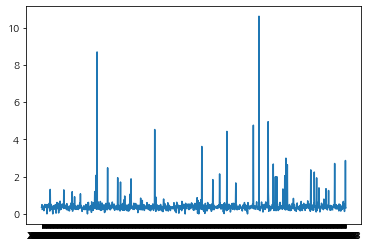

In [254]:
# 결측치 대체 후 평균값 plot
plt.plot(round(ex2.mean(),3))

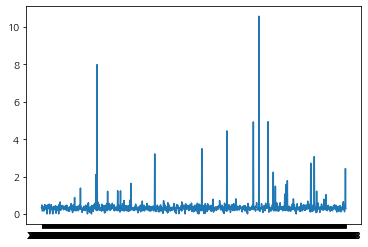

In [255]:
# 결측치 대체 후 중앙값 plot
plt.plot(ex2.median())

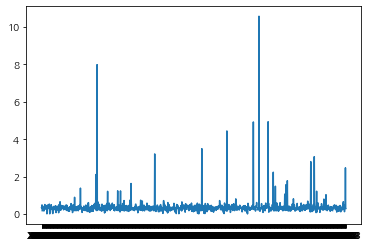

In [256]:
# 결측치 대체 전 중앙값 plot
plt.plot(train.median())

In [257]:
# 중앙값 보다 큰 값 평균으로 결측치 처리 후 train 데이터 = ex2
ex2.head()

,Time,X692,X1272,X553,X1299,X4,X598,X1003,X1010,X1216,...,X1164,X656,X1287,X324,X767,X1271,X1288,X58,X1033,X1163
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2. 이후 초반에 발생한 NA값을 제외하고 나머지 결측치 값을 최빈값으로 대체